In [45]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.init as init
import numpy as np


import kagglehub
import data

import importlib
importlib.reload(data)

<module 'data' from 'd:\\Universidad\\Aprendizaje-Automatico-y-Big-Data\\Practica5\\data.py'>

In [ ]:
#Aqui habría que poner la linea de codigo para descargar el dataset
#El dataset tiene un par de fotos en los que el formato del nombre de la imagen esta mal; yo las he borrado directamente pero en google colab no se puedem borrar archivos
#por eso no he puesto el codigo de la descarga
#Cuando hagas pruebas tu carga el dataset entero en dataset = data.ImgDataset(utk_ruta,transform=transform) y cuando los tengas cargados quita las foto de dataset que den problemas
#Son aquellas que eran de la forma edad_año_fecha.jpg


In [70]:
#solo sirve en mi ordena ichi esta linea
utk_ruta = "C:\\Users\\Adrian\\.cache\\kagglehub\\datasets\\jangedoo\\utkface-new\\versions\\1\\UTKFace"

# Transformar dataset 
Transformamos las imagenes en una estructura de datos con la que podamos trabajar

In [48]:
#Adaptamos las imagenes a un dataset
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #Esto normalizara las imagenes
dataset = data.ImgDataset(utk_ruta,transform=transform) #Pasamos las imagenes a la estructura de datos

GENERO = ('Hombre','Mujer')
RAZA = ('Blanco','Negrata','Chinito','Indio','Otros')


In [71]:
# Crear los DataLoaders
train_dataloader,test_dataloader = data.entrenamientoTest(dataset=dataset,test_size=0.2,batch_size=4)

print(len(train_dataloader))
print(len(test_dataloader))

4741
1186


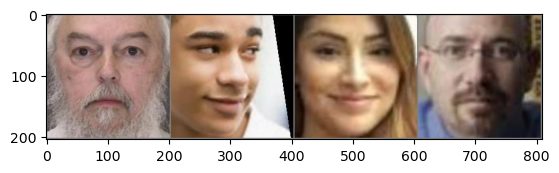

Edad:    70.0  17.0  26.0  56.0
Genero: Hombre Hombre Mujer Hombre
Raza:   Blanco Otros Blanco Blanco


In [72]:
# Display image and label.
imagenes, edades,generos,razas = next(iter(train_dataloader))

# show images
data.mostrarImg(imagenes)
print('Edad:  ',' '.join('%5s' % edades[j].item() for j in range(4)))
print('Genero:',' '.join('%5s' % GENERO[generos[j].item()] for j in range(4)))
print('Raza:  ',' '.join('%5s' % RAZA[razas[j].item()] for j in range(4)))


# Modelo 1: Denzel Washington

Entrenaremos 3 modelos distintos, uno por cada objetivo que queremos predecir. 

Ambos modelos tendrán la misma estructura excepto en la ultima capa. 

Además el entrenamiento será distinto para cada uno de ellos pues utilizaremos distintos criterios y optimizadores segun el objetivo

In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DenzelWashington(nn.Module):
    def __init__(self,output_layers):
        super().__init__()

        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.pool2 = nn.MaxPool2d(4, 4)
       
        self.fc1 = nn.Linear(12 * 11 * 11, 500)
        self.fcout = nn.Linear(500, output_layers)

        self.apply(self._init_weights)  # Aplicar la inicialización de pesos

    def _init_weights(self, m):
        """Inicializa los pesos de la red"""
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            init.normal_(m.weight, mean=0.0, std=0.02)
            if m.bias is not None:
                init.constant_(m.bias, 0)

    def forward(self, x):

        x = self.pool1(x) #3 fotos 100x100
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.fcout(x)
        return x




In [74]:
#Esto sirve para ver en que dispositivo se entrena.
#GPU(cuda) es mas rapido que CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Entrenando en: {device}")

Entrenando en: cuda


## Género

In [75]:
import torch.optim as optim

DWGenero = DenzelWashington(output_layers=2).to(device)
crossEntropyLoss = nn.CrossEntropyLoss()
optimizer = optim.Adam(DWGenero.parameters(), lr=0.0001)

In [76]:
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]

        imagenes, _, generos, _ = data
        imagenes, generos = imagenes.to(device),generos.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        generosPred = DWGenero(imagenes)
        
        lossGenero = crossEntropyLoss(generosPred,generos)
       
        lossGenero.backward()
        optimizer.step()

        # print statistics
        running_loss += lossGenero.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
            running_loss = 0.0

print('Finished Training')
torch.save(DWGenero.state_dict(), './DWGenero.pth')

KeyboardInterrupt: 

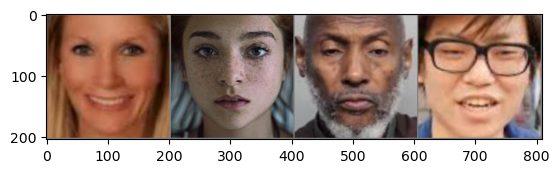

Valor real
Genero: Hombre Mujer Mujer Hombre
Predicciones
Genero: Mujer Mujer Mujer Mujer


In [ ]:
#Pruebas
imagenes, _,genero,_ = next(iter(train_dataloader))
imagenes = imagenes.to(device)

predicciones = DWGenero(imagenes)
_ , predicciones = torch.max(predicciones, 1)


data.mostrarImg(imagenes)
print("Valor real")
print('Genero:',' '.join('%5s' % GENERO[generos[j].item()] for j in range(4)))
print("Predicciones")
print('Genero:',' '.join('%5s' % GENERO[predicciones[j].item()] for j in range(4)))
